In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from modules.data import disc_to_cont, data_obj as data

device = "cuda"

Failed to import openseespy on Windows.


c:\Users\aglor\anaconda3\envs\ML\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


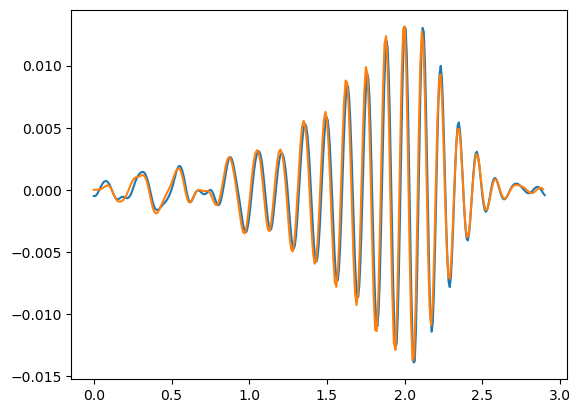

In [2]:
ffun = disc_to_cont(data.t, data.load)

t = np.linspace(data.t.min(), 2.9, 400)
fhat = np.fft.fft(-ffun(t) * 1e3)
xi = np.fft.fftfreq(len(fhat), d=t[1]-t[0])

Fhat = np.zeros((4, len(fhat)), dtype=np.complex128)
Fhat[3, :] = fhat

Uhat = np.zeros_like(Fhat)
for col in range(Uhat.shape[1]):
    A = (2*np.pi*1j*xi[col])**2 * data.M + (2*np.pi*1j*xi[col]) * data.C + data.k_basis * data.Y
    Uhat[:, col] = (np.linalg.inv(A) @ Fhat[:, col].reshape(-1, 1)).squeeze()

U = np.fft.ifft(Uhat)
plt.plot(t, U[3])
plt.plot(data.t[:290], data.data_dict["Disp_4_2D"][:290])

In [3]:
XI = torch.as_tensor(xi).to("cuda")
FHAT = torch.as_tensor(Fhat).to("cuda")
UHAT = torch.as_tensor(Uhat).to("cuda")
KB = torch.as_tensor(data.k_basis).to("cuda")
M = torch.as_tensor(data.M).to("cuda")

E = torch.as_tensor(np.random.rand(1)).to("cuda")
E.requires_grad = True
optimizer = torch.optim.Adam([E], lr=1e-1)
criterion = torch.nn.MSELoss()
sigmoid = torch.nn.Sigmoid()

for epoch in range(200):
    optimizer.zero_grad()
    cumulative_error = 0

    # limit 0 < E / 10^7 < 10
    K = (sigmoid(E) * 10) * KB * 1e7
    C = data.a0 * M + data.a1 * K

    for col in range(UHAT.shape[1]):
        A = (2 * np.pi * 1j * XI[col]) ** 2 * M + (2 * np.pi * 1j * XI[col]) * C + K
        error = torch.linalg.inv(A) @ FHAT[:, col].reshape(-1, 1) - UHAT[
            :, col
        ].reshape(-1, 1)
        # error = A @ UHAT[:, col].reshape(-1, 1) - FHAT[:, col].reshape(-1, 1)
        error = (error.real + error.imag)[[1, 3], :]  # only use sensor dims
        cumulative_error = cumulative_error + criterion(error, error * 0)

    cumulative_error.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch %d: E = %.5g" % (epoch, (sigmoid(E).item() * 10) * 1e7))

Epoch 0: E = 6.8995e+07
Epoch 10: E = 6.8474e+07
Epoch 20: E = 6.8699e+07
Epoch 30: E = 6.9365e+07
Epoch 40: E = 6.947e+07
Epoch 50: E = 6.9367e+07
Epoch 60: E = 6.929e+07
Epoch 70: E = 6.9258e+07
Epoch 80: E = 6.9248e+07
Epoch 90: E = 6.9244e+07
Epoch 100: E = 6.924e+07
Epoch 110: E = 6.9235e+07
Epoch 120: E = 6.923e+07
Epoch 130: E = 6.9227e+07
Epoch 140: E = 6.9227e+07
Epoch 150: E = 6.9229e+07
Epoch 160: E = 6.9229e+07
